# Importation

## Modules and files

In [134]:
from pathlib import Path
import pandas as pd, numpy as np, unicodedata, re
import matplotlib.pyplot as plt
from itertools import combinations

def find_goal_root(start: Path | None = None) -> Path:
    start = Path.cwd() if start is None else Path(start)
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "results").exists():
            return p
        if p.name == "GOAL":
            return p
    return start  # fallback

GOAL_ROOT  = find_goal_root()
DATA_DIR   = GOAL_ROOT / "data"
RESULTS_DIR = GOAL_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"GOAL root:   {GOAL_ROOT.resolve()}")
print(f"Data dir:    {DATA_DIR.resolve()}")
print(f"Results dir: {RESULTS_DIR.resolve()}")

# Helpers
def read_data_csv(name: str, **kwargs):
    return pd.read_csv(DATA_DIR / name, **kwargs)

def read_result_csv(name: str, **kwargs):
    return pd.read_csv(RESULTS_DIR / name, **kwargs)

def save_result_csv(df: pd.DataFrame, name: str, **kwargs):
    return df.to_csv(RESULTS_DIR / name, **kwargs)

GOAL root:   /Users/antoinem/Desktop/Thesis/GitHubFiles/GOAL
Data dir:    /Users/antoinem/Desktop/Thesis/GitHubFiles/GOAL/data
Results dir: /Users/antoinem/Desktop/Thesis/GitHubFiles/GOAL/results


## Loading of data

In [135]:
# Load the data from CSVs (fixed locations)
df = read_result_csv('player_match_ratings.csv', low_memory=False)   # from GOAL/results
g  = read_data_csv('top100guardian.csv', low_memory=False)           # from GOAL/data

print(df.head())
print(g.head())

  competition        date                    match    team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  France  Sub      Sub   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   FW       FW   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   

              player  goals  assists  shots_ontarget  ...  betweenness2goals  \
0    Anthony Martial      0        0               1  ...           0.000000   
1     Olivier Giroud      1        0               2  ...           0.050000   
2  Laurent Koscielny      0        0               0  ...           0.000000   
3       N'Golo Kante      0        1               0  ...           0.032258   
4         Paul Pogba      0        0               1  ...           0.000000   

   win  lost  is_home_team  minutesPlayed  game_duration  non_

# Model

## Model Writing

In [136]:
# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating (target mean)
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.2        # impact of opponent difficulty on expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent (difficulty>0.5) lowers expectation; easier raises it
    return base_note - diff_impact * (difficulty - 0.5) * 2.0


def compute_ratings(pm,
                    K=K,
                    diff_impact=DIFF_IMPACT,
                    diff_update_amp=0.0,     # amplify updates by opponent level
                    diff_power=1.0,          # optional nonlinearity of difficulty term
                    keep_global_mean=True,
                    recenter_each_step=False):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    keep_global_mean:
        If True, enforce final (or stepwise) mean rating == BASE_NOTE.
    recenter_each_step:
        If True, re-centers after each date block. Else only one final shift.
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    def _diff_term(d):
        # centered, scaled to [-1, +1]; allow optional nonlinearity
        t = (float(d) - 0.5) * 2.0
        return np.sign(t) * (abs(t) ** diff_power)

    if recenter_each_step:
        for date, day_df in pm.groupby('date'):
            for row in day_df.itertuples(index=False):
                player = row.player
                # Seed an initial point at BASE_NOTE before the first match
                if player not in player_rating:
                    player_rating[player] = BASE_NOTE
                    seed_date = pd.to_datetime(row.date) - pd.Timedelta(microseconds=1)
                    history.append((seed_date, row.match, player, BASE_NOTE, np.nan, np.nan, BASE_NOTE))

                perf   = row.P
                w_min  = row.w_min
                diff   = 0.5 if pd.isna(row.difficulty) else row.difficulty
                match  = row.match
                R_old  = player_rating.get(player, BASE_NOTE)

                if pd.isna(perf):
                    history.append((row.date, match, player, R_old, np.nan, np.nan, R_old))
                    continue

                E = expected_performance(BASE_NOTE, diff, diff_impact)
                scale = max(0.0, 1.0 + diff_update_amp * _diff_term(diff))  # amplify by opponent level
                delta = K * w_min * scale * (perf - E)
                R_new = R_old + delta
                player_rating[player] = R_new
                history.append((row.date, match, player, R_old, perf, E, R_new))
    else:
        for row in pm.itertuples(index=False):
            player = row.player
            date   = row.date
            match  = row.match

            # Seed an initial point at BASE_NOTE before the first match
            if player not in player_rating:
                player_rating[player] = BASE_NOTE
                seed_date = pd.to_datetime(date) - pd.Timedelta(microseconds=1)
                history.append((seed_date, match, player, BASE_NOTE, np.nan, np.nan, BASE_NOTE))

            perf   = row.P
            w_min  = row.w_min
            diff   = 0.5 if pd.isna(row.difficulty) else row.difficulty
            R_old  = player_rating.get(player, BASE_NOTE)

            if pd.isna(perf):
                history.append((date, match, player, R_old, np.nan, np.nan, R_old))
                continue

            E = expected_performance(BASE_NOTE, diff, diff_impact)
            scale = max(0.0, 1.0 + diff_update_amp * _diff_term(diff))  # amplify by opponent level
            delta = K * w_min * scale * (perf - E)
            R_new = R_old + delta
            player_rating[player] = R_new
            history.append((date, match, player, R_old, perf, E, R_new))

        # Final global recenter
        if keep_global_mean and player_rating:
            final_mean = np.mean(list(player_rating.values()))
            shift = BASE_NOTE - final_mean
            if abs(shift) > 1e-12:
                history = [(d,m,p,Rb+shift,P,E,Ra+shift) for (d,m,p,Rb,P,E,Ra) in history]
                for p in player_rating:
                    player_rating[p] += shift

    ratings_ts = pd.DataFrame(history,
                              columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep
# ------------------
pm0 = read_result_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date","match","player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty (scale opponent_ranking per competition)
max_rank_df = (pm0.groupby("competition", dropna=False)["opponent_ranking"]
                  .max().rename("max_rank").reset_index())
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average (ignores NaNs)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings (final mean preserved at BASE_NOTE)
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg, keep_global_mean=True, recenter_each_step=False)
ts_hum, fin_hum = compute_ratings(pm_hum, keep_global_mean=True, recenter_each_step=False)
ts_ai,  fin_ai  = compute_ratings(pm_ai,  keep_global_mean=True, recenter_each_step=False)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

## Model mechanics visualization

In [137]:
# Visualization: model mechanics for one player (clean layout, fixed y-range 4–8)
def plot_model_mechanics(player: str,
                         ts=globals().get('ts_tuned'),
                         pm=globals().get('pm_best'),
                         save: bool = True,
                         rating_ylim=(4, 8)):
    """
    Panels:
      1) Rating trajectory with per-match update delta bars
      2) Observed P vs Expected E
      3) Minutes weight and difficulty
    """

    if ts is None or len(ts) == 0:
        raise RuntimeError("ts_tuned not found. Compute tuned system first.")
    if pm is None:
        base_cols = ["date","match","player","w_min","difficulty"]
        pm = pm0[base_cols].copy()

    # Data for this player
    df_ts = (ts[ts["player"] == player]
             .sort_values(["date","match"])
             .reset_index(drop=True))
    if df_ts.empty:
        raise ValueError(f"No tuned time series for player '{player}'.")

    # Join minutes weight and difficulty (context)
    cols_ctx = ["date","match","player","w_min","difficulty"]
    ctx = pm[cols_ctx].drop_duplicates()
    df = df_ts.merge(ctx, on=["date","match","player"], how="left")

    # Update deltas
    df["delta"] = df["rating_after"] - df["rating_before"]

    # Seed row has NaN P/E; exclude it for P/E plots
    seed_mask = df["P"].isna() & df["E"].isna()
    df_eff = df[~seed_mask].reset_index(drop=True)

    # X axes
    x_all = np.arange(len(df))               # includes seed at 0
    x_eff = np.arange(len(df_eff)) + 1       # after seed

    # Colors for deltas
    delta_colors = np.where(df["delta"] >= 0, "#2ca02c", "#d62728")

    # Read config for footer
    try:
        amp = float(SELECTED_DIFF_UPDATE_AMP)
    except Exception:
        amp = 0.0

    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(12, 9), sharex=True, constrained_layout=True,
        gridspec_kw={"height_ratios":[2.2, 1.3, 1.4]}
    )

    # 1) Rating trajectory + delta bars (bars start at rating_before to fit y-limits)
    ax1.plot(x_all, df["rating_after"], color="#1f77b4", lw=2.0, marker="o", label="rating_after")
    deltas = df["delta"].to_numpy().copy()
    if len(deltas) > 0:
        deltas[0] = 0.0  # seed
    ax1.bar(x_all, deltas, bottom=df["rating_before"], color=delta_colors, alpha=0.25, width=0.8, label="update delta")
    ax1.axhline(BASE_NOTE, color="0.3", ls="--", lw=1.2, label=f"BASE_NOTE={BASE_NOTE:.2f}")
    if rating_ylim is not None:
        ax1.set_ylim(*rating_ylim)
    ax1.set_title(f"Model mechanics for {player} — tuned system")
    ax1.set_ylabel("Rating")
    ax1.legend(loc="upper left")

    # 2) Observed vs Expected performance
    ax2.plot(x_eff, df_eff["P"], color="#2ca02c", lw=2.0, marker="o", label="Observed P")
    ax2.plot(x_eff, df_eff["E"], color="#ff7f0e", lw=2.0, marker="o", label="Expected E")
    ax2.set_ylabel("Rating scale")
    ax2.legend(loc="upper left")

    # 3) Minutes weight and Opponent difficulty
    bars = ax3.bar(x_eff - 0.2, df_eff["w_min"].clip(0, 1), width=0.4, color="#7f7f7f", alpha=0.85, label="minutes weight (0–1)")
    ax3b = ax3.twinx()
    ax3b.plot(x_eff, df_eff["difficulty"], color="#9467bd", lw=2.0, marker="o", label="difficulty (0–1)")
    ax3.set_ylabel("Minutes weight")
    ax3b.set_ylabel("Difficulty")
    ax3.set_xlabel("Match index (after seed)")
    lines = [bars] + ax3b.get_lines()
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc="upper left")

    # Footer config
    fig.text(0.01, 0.005, f"K={K}, DIFF_IMPACT={DIFF_IMPACT}, DIFF_UPDATE_AMP={amp}, MINUTES_CAP={MINUTES_CAP}",
             fontsize=9, color="0.35")

    if save:
        safe_name = re.sub(r"[^a-z0-9]+", "_", player.lower()).strip("_")
        out_path = RESULTS_DIR / f"mechanics_{safe_name}.png"
        fig.savefig(out_path, dpi=180, bbox_inches="tight")
        print(f"Saved figure to {out_path}")

    plt.show()

Selected: Eric Maxim Choupo-Moting
Saved figure to /Users/antoinem/Desktop/Thesis/GitHubFiles/GOAL/results/mechanics_eric_maxim_choupo_moting.png


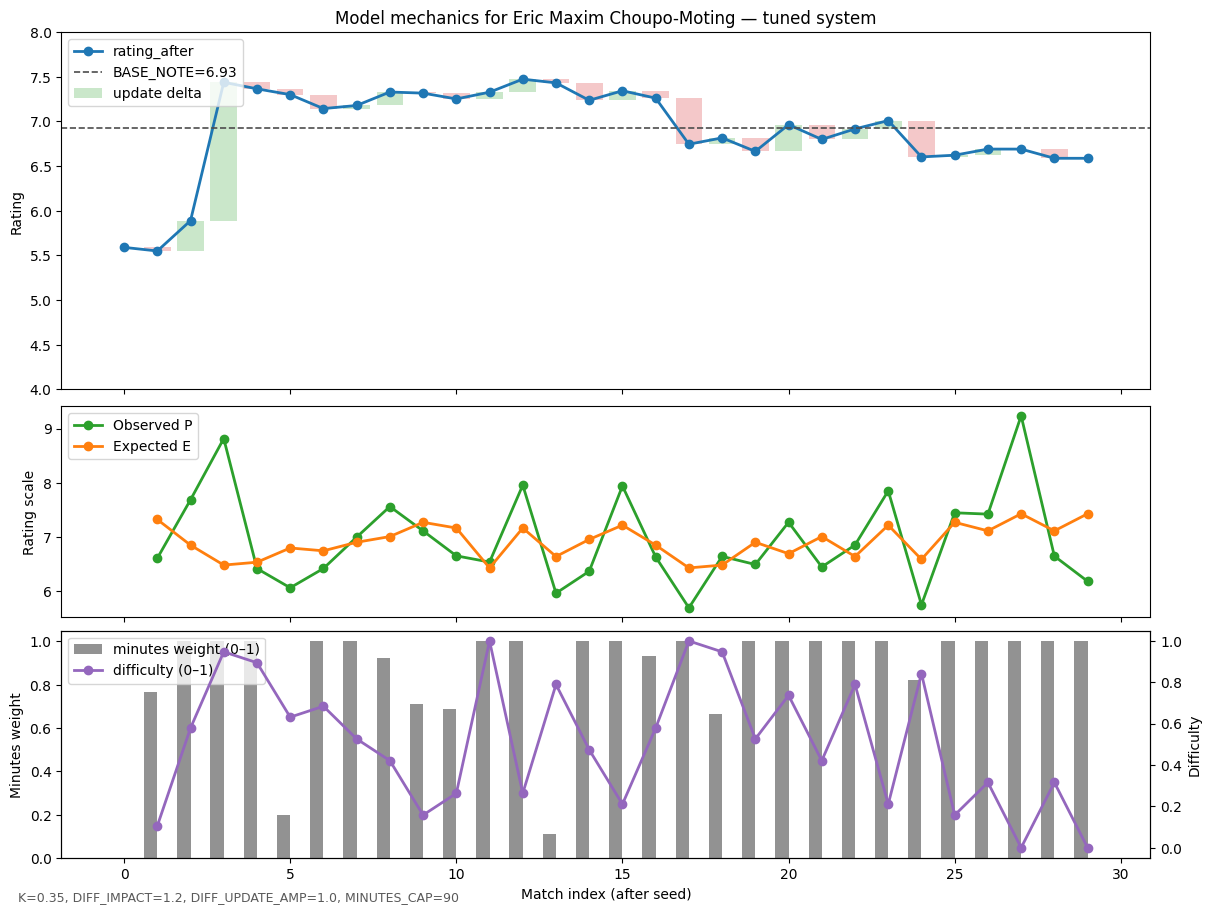

In [138]:
# Select Choupo‑Moting and plot

assert "ts_tuned" in globals() and "pm0" in globals(), "Run the model first."

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return re.sub(r"[^a-z0-9]+", " ", s.lower()).strip()

players = sorted(set(ts_tuned["player"]))
norm_map = {p: _norm(p) for p in players}

# Accept common variants (typo-friendly)
targets = ["choupo moting"]

matches = [p for p, n in norm_map.items() if any(t in n for t in targets)]
if not matches:
    raise RuntimeError("Choupo‑Moting not found in tuned series.")
player = matches[0]

print(f"Selected: {player}")
plot_model_mechanics(player, ts=ts_tuned, pm=globals().get("pm_best"), save=True, rating_ylim=(4, 8))

# GridSearch

## Spearman GridSearch (not used)

Guardian players in our data (ENG or BUND): 37
  Evaluation PL 2017-18 overlap: 32 players
  Evaluation Bundesliga 2017-18 overlap: 6 players

Best configuration (combined):
  w_human=0.25  diff_impact=1.2  diff_update_amp=1.0  Score=0.528  n_total=38


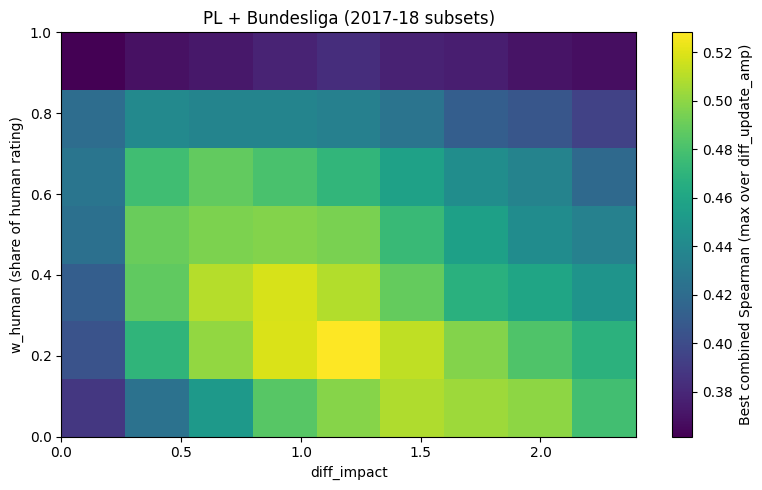

In [139]:
# Guardian overlap + grid search on diff_impact and human/non-human mixing (PL + Bundesliga)

# ---------- helpers ----------
def norm_name(s):
    if pd.isna(s): 
        return ""
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def spearman_from_rank_maps(a_map, b_map):
    keys = sorted(set(a_map) & set(b_map))
    if not keys: 
        return np.nan, 0
    a = pd.Series([a_map[k] for k in keys], dtype=float)
    b = pd.Series([b_map[k] for k in keys], dtype=float)
    # Pearson on ranks == Spearman
    return a.corr(b, method="pearson"), len(keys)

def build_pm_mix(pm0, w_h):
    # weighted mix with NA-robust fallback
    pm = pm0[["date","match","player","w_min","difficulty"]].copy()
    h = pm0["human_rating"]
    a = pm0["non_human_rating"]
    both = (~h.isna()) & (~a.isna())
    p = pd.Series(index=pm.index, dtype=float)
    p[both] = w_h * h[both] + (1 - w_h) * a[both]
    p[~both] = h.where(a.isna(), a)[~both]
    pm["P"] = p
    return pm

# ---------- Guardian list ----------

# Explicit column names from the file
name_col   = "Name"
rank_col   = "Rank"
league_col = "Domestic league"

# Keep only rows with a valid rank and name
g = g.dropna(subset=[name_col, rank_col])
g["guardian_rank"] = pd.to_numeric(g[rank_col], errors="coerce")
g = g.dropna(subset=["guardian_rank"]).copy()

# Flags: Premier League (England) and Bundesliga (Germany)
vals = g[league_col].astype(str).str.strip().str.lower()
g["_eng_flag"]  = vals.eq("england")
g["_bund_flag"] = vals.eq("germany")

# Keep players in England OR Germany
g_sel = g[g["_eng_flag"] | g["_bund_flag"]].copy()
g_sel["key"] = g_sel[name_col].apply(norm_name)

# ---------- Our players + keys ----------
our_players = pd.Series(pm0["player"].unique(), name="player")
key_map = {p: norm_name(p) for p in our_players}
pm0["_key"] = pm0["player"].map(key_map)

# Guardian players present in our data
guardian_present = g_sel[g_sel["key"].isin(set(pm0["_key"]))].copy()
guardian_present = guardian_present[["key","guardian_rank", name_col]].drop_duplicates()
guardian_rank_map_all = dict(zip(guardian_present["key"], guardian_present["guardian_rank"]))

# Evaluation subsets: PL and Bundesliga players who have at least 1 match in our data
players_in_pl = set(pm0.loc[pm0["competition"] == "Premier League 2017-18", "_key"].unique())
players_in_bl = set(pm0.loc[pm0["competition"] == "Bundesliga 2017-18",      "_key"].unique())

eval_pl = sorted(set(guardian_present["key"]) & players_in_pl)
eval_bl = sorted(set(guardian_present["key"]) & players_in_bl)

print(f"Guardian players in our data (ENG or BUND): {len(guardian_present)}")
print(f"  Evaluation PL 2017-18 overlap: {len(eval_pl)} players")
print(f"  Evaluation Bundesliga 2017-18 overlap: {len(eval_bl)} players")

if len(eval_pl) == 0 and len(eval_bl) == 0:
    raise ValueError("No overlap between Guardian and PL/Bundesliga 2017-18 players in your data.")

# ---------- Grid search settings ----------
diff_values        = [0.0, 0.5, 0.75, 1.0, 1.2, 1.5, 1.8, 2.0, 2.4]
human_weights      = [0.0, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]
diff_update_values = [0.0, 0.25, 0.5, 0.75, 1.0]   # if your compute_ratings supports diff_update_amp

rows = []
best_comb = {"score": -np.inf, "params": None, "final": None}
best_pl   = {"score": -np.inf, "params": None, "final": None}
best_bl   = {"score": -np.inf, "params": None, "final": None}

for w_h in human_weights:
    pm_mix = build_pm_mix(pm0, w_h)
    for dv in diff_values:
        for amp in diff_update_values:
            ts_tmp, fin_tmp = compute_ratings(pm_mix,
                                              K=K,
                                              diff_impact=dv,
                                              diff_update_amp=amp,
                                              keep_global_mean=True,
                                              recenter_each_step=False)
            fin_tmp = fin_tmp.sort_values("final_rating", ascending=False).reset_index(drop=True)
            fin_tmp["rank"] = fin_tmp.index + 1
            fin_tmp["_key"] = fin_tmp["player"].map(lambda x: key_map.get(x, norm_name(x)))
            our_rank_map = dict(zip(fin_tmp["_key"], fin_tmp["rank"]))

            g_map = guardian_rank_map_all

            our_pl = {k: our_rank_map[k] for k in eval_pl if k in our_rank_map}
            spearman_pl, n_pl = spearman_from_rank_maps({k: g_map[k] for k in eval_pl if k in g_map}, our_pl)

            our_bl = {k: our_rank_map[k] for k in eval_bl if k in our_rank_map}
            spearman_bl, n_bl = spearman_from_rank_maps({k: g_map[k] for k in eval_bl if k in g_map}, our_bl)

            n_tot = (n_pl or 0) + (n_bl or 0)
            score_comb = np.nan
            if n_tot > 0:
                wpl = (n_pl or 0) / n_tot
                wbl = (n_bl or 0) / n_tot
                score_comb = (0 if pd.isna(spearman_pl) else wpl * spearman_pl) + \
                             (0 if pd.isna(spearman_bl) else wbl * spearman_bl)

            top5 = fin_tmp.head(5)["player"].tolist()
            rows.append({
                "w_human": w_h,
                "diff_impact": dv,
                "diff_update_amp": amp,
                "spearman_PL": spearman_pl, "n_PL": n_pl,
                "spearman_BL": spearman_bl, "n_BL": n_bl,
                "score_combined": score_comb, "n_total": n_tot,
                "top5": ", ".join(top5)
            })

            if n_tot > 0 and pd.notna(score_comb) and score_comb > best_comb["score"]:
                best_comb = {"score": score_comb, "params": (w_h, dv, amp), "final": fin_tmp.copy()}
            if (n_pl or 0) > 0 and pd.notna(spearman_pl) and spearman_pl > best_pl["score"]:
                best_pl = {"score": spearman_pl, "params": (w_h, dv, amp), "final": fin_tmp.copy()}
            if (n_bl or 0) > 0 and pd.notna(spearman_bl) and spearman_bl > best_bl["score"]:
                best_bl = {"score": spearman_bl, "params": (w_h, dv, amp), "final": fin_tmp.copy()}

results = pd.DataFrame(rows).sort_values(
    ["score_combined","n_total","spearman_PL","spearman_BL"], ascending=[False, False, False, False]
).reset_index(drop=True)

print("\nBest configuration (combined):")
print(f"  w_human={best_comb['params'][0]}  diff_impact={best_comb['params'][1]}  diff_update_amp={best_comb['params'][2]}  "
      f"Score={best_comb['score']:.3f}  n_total={results.iloc[0]['n_total']}")

# ---------- Heatmap: best score across diff_update_amp for each (w_human, diff_impact) ----------
pivot = (results
         .groupby(["w_human","diff_impact"])["score_combined"]
         .max()
         .unstack("diff_impact"))

plt.figure(figsize=(8,5))
im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()],
                cmap="viridis")
plt.colorbar(im, label="Best combined Spearman (max over diff_update_amp)")
plt.xlabel("diff_impact")
plt.ylabel("w_human (share of human rating)")
plt.title("PL + Bundesliga (2017-18 subsets)")
plt.tight_layout()
plt.show()


In [140]:
# Apply best grid-search result to the model and export tuned ratings

# 1) Read best params from the previous grid-search if available; else use the shown best
if 'best_comb' in globals() and best_comb.get('params') is not None:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best_comb['params']
elif 'best' in globals() and best.get('params') is not None:
    # fallback to PL-only search if that's what you ran last
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best['params']
else:
    # fallback to values reported in your plot
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = 0.25, 1.2, 1.0

print(f"Using tuned params -> w_human={SELECTED_W_HUMAN}, diff_impact={SELECTED_DIFF_IMPACT}, "
      f"diff_update_amp={SELECTED_DIFF_UPDATE_AMP}")

# 2) Build the mixed-performance dataset with NA-robust fallback
pm_best = pm0[["date","match","player","w_min","difficulty"]].copy()
h = pm0["human_rating"]
a = pm0["non_human_rating"]
both = (~h.isna()) & (~a.isna())
P = pd.Series(index=pm_best.index, dtype=float)
P[both]   = SELECTED_W_HUMAN * h[both] + (1.0 - SELECTED_W_HUMAN) * a[both]
P[~both]  = h.where(a.isna(), a)[~both]  # if only one source present, use it
pm_best["P"] = P

# 3) Compute tuned ratings with opponent-level update amplification
ts_tuned, fin_tuned = compute_ratings(
    pm_best,
    K=K,
    diff_impact=SELECTED_DIFF_IMPACT,
    diff_update_amp=SELECTED_DIFF_UPDATE_AMP,
    keep_global_mean=True,
    recenter_each_step=False
)

# 4) Save and preview results
ts_tuned["system"] = "tuned"
fin_tuned = fin_tuned.sort_values("final_rating", ascending=False).reset_index(drop=True)

save_result_csv(ts_tuned, "ratings_timeseries_tuned.csv", index=False)
save_result_csv(fin_tuned, "final_ratings_tuned.csv", index=False)

print("Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv")
print("Global mean (tuned) final rating:", round(fin_tuned["final_rating"].mean(), 6))
print("\nTop 10 (tuned):")
print(fin_tuned.head(10)[["player","final_rating"]])

Using tuned params -> w_human=0.25, diff_impact=1.2, diff_update_amp=1.0
Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv
Global mean (tuned) final rating: 6.926722

Top 10 (tuned):
              player  final_rating
0    Kevin De Bruyne     23.734262
1        Eden Hazard     18.706397
2         Harry Kane     17.087126
3      Mohamed Salah     17.036166
4  Christian Eriksen     16.087676
5         Leroy Sane     15.590409
6         Paul Pogba     14.477379
7     Jan Vertonghen     14.299808
8      Harry Maguire     13.935246
9      Sergio Aguero     13.889334


## Split GridSearch (used)

In [141]:
# Holdout grid search (50/50 split of Guardian-overlap players), interpretable metrics

# Union of evaluation keys (PL ∪ Bundesliga players present in our data)
keys_all = sorted(set(eval_pl) | set(eval_bl))
assert len(keys_all) >= 4, f"Not enough overlap to hold out. Found {len(keys_all)} players."

# Deterministic 50/50 split
rng = np.random.default_rng(42)
perm = rng.permutation(len(keys_all))
half = len(keys_all) // 2
train_keys = set(np.array(keys_all)[perm[:half]])
test_keys  = set(np.array(keys_all)[perm[half:]])
print(f"Holdout split -> train={len(train_keys)} test={len(test_keys)} (total={len(keys_all)})")

guardian_map = guardian_rank_map_all  # key -> Guardian rank

def our_rank_map_for_params(pm0, w_h, dv, amp):
    pm_mix = build_pm_mix(pm0, w_h)
    ts_tmp, fin_tmp = compute_ratings(pm_mix,
                                      K=K,
                                      diff_impact=dv,
                                      diff_update_amp=amp,
                                      keep_global_mean=True,
                                      recenter_each_step=False)
    fin_tmp = fin_tmp.sort_values("final_rating", ascending=False).reset_index(drop=True)
    fin_tmp["rank"] = fin_tmp.index + 1
    fin_tmp["_key"] = fin_tmp["player"].map(lambda x: key_map.get(x, norm_name(x)))
    return dict(zip(fin_tmp["_key"], fin_tmp["rank"]))

def pairwise_agreement_pct(g_map, o_map, keys):
    ks = [k for k in keys if k in g_map and k in o_map]
    good = 0
    total = 0
    for i, j in combinations(ks, 2):
        gi, gj = g_map[i], g_map[j]
        oi, oj = o_map[i], o_map[j]
        if gi == gj or oi == oj:
            continue  # skip ties
        total += 1
        if (gi < gj) == (oi < oj):
            good += 1
    if total == 0:
        return np.nan
    return 100.0 * good / total

def topk_overlap_pct(g_map, o_map, keys, k=10):
    ks = [k for k in keys if k in g_map and k in o_map]
    if not ks:
        return np.nan
    g_sorted = sorted(((k, g_map[k]) for k in ks), key=lambda t: t[1])
    o_sorted = sorted(((k, o_map[k]) for k in ks), key=lambda t: t[1])
    top_g = [k for k, _ in g_sorted[:k]]
    top_o = [k for k, _ in o_sorted[:k]]
    denom = min(len(top_g), len(top_o))
    if denom == 0:
        return np.nan
    return 100.0 * (len(set(top_g) & set(top_o)) / denom)

# Search space (reuse your earlier ranges)
diff_values        = [0.0, 0.5, 0.75, 1.0, 1.2, 1.5, 1.8, 2.0, 2.4]
human_weights      = [0.0, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]
diff_update_values = [0.0, 0.25, 0.5, 0.75, 1.0]

rows = []
best_holdout = {"score": -np.inf, "params": None}

for w_h in human_weights:
    for dv in diff_values:
        for amp in diff_update_values:
            our_map = our_rank_map_for_params(pm0, w_h, dv, amp)

            train_pair = pairwise_agreement_pct(guardian_map, our_map, train_keys)
            train_top10 = topk_overlap_pct(guardian_map, our_map, train_keys, k=10)

            # Objective = pairwise agreement on train
            score = -np.inf if pd.isna(train_pair) else float(train_pair)

            # Evaluate on test as well (for reporting)
            test_pair = pairwise_agreement_pct(guardian_map, our_map, test_keys)
            test_top10 = topk_overlap_pct(guardian_map, our_map, test_keys, k=10)

            rows.append({
                "w_human": w_h,
                "diff_impact": dv,
                "diff_update_amp": amp,
                "train_pairwise_agree_pct": train_pair,
                "train_top10_overlap_pct": train_top10,
                "test_pairwise_agree_pct": test_pair,
                "test_top10_overlap_pct": test_top10,
            })

            if score > best_holdout["score"]:
                best_holdout = {"score": score, "params": (w_h, dv, amp)}

holdout_results = pd.DataFrame(rows).sort_values(
    ["train_pairwise_agree_pct", "train_top10_overlap_pct"],
    ascending=False
).reset_index(drop=True)

print("Best params from holdout search (train objective = pairwise agreement %):")
print(f"  w_human={best_holdout['params'][0]}  diff_impact={best_holdout['params'][1]}  "
      f"diff_update_amp={best_holdout['params'][2]}  train_pair={best_holdout['score']:.1f}%")

# Show top 10 rows of the search
display(holdout_results.head(10))

Holdout split -> train=18 test=19 (total=37)
Best params from holdout search (train objective = pairwise agreement %):
  w_human=0.5  diff_impact=0.5  diff_update_amp=1.0  train_pair=83.7%


,w_human,diff_impact,diff_update_amp,train_pairwise_agree_pct,train_top10_overlap_pct,test_pairwise_agree_pct,test_top10_overlap_pct
0,0.50,0.50,1.00,83.660131,80.0,69.590643,60.0
1,0.50,0.75,1.00,83.006536,80.0,67.836257,60.0
2,0.60,0.75,1.00,83.006536,80.0,67.836257,60.0
3,0.40,1.00,1.00,82.352941,80.0,69.005848,60.0
4,0.60,1.00,0.75,82.352941,70.0,67.251462,60.0
5,0.40,0.50,1.00,81.699346,80.0,69.590643,60.0
6,0.40,0.75,1.00,81.699346,80.0,69.590643,60.0
7,0.50,1.00,1.00,81.699346,80.0,67.836257,60.0
8,0.60,1.00,1.00,81.045752,80.0,67.251462,60.0
9,0.75,1.00,1.00,81.045752,80.0,66.081871,70.0


In [142]:
# Apply best grid-search result to the model and export tuned ratings

# 1) Read best params from the previous grid-search if available; else use the shown best
if 'best_holdout' in globals() and best_holdout.get('params') is not None:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best_holdout['params']
elif 'best_comb' in globals() and best_comb.get('params') is not None:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best_comb['params']
elif 'best' in globals() and best.get('params') is not None:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = best['params']
else:
    SELECTED_W_HUMAN, SELECTED_DIFF_IMPACT, SELECTED_DIFF_UPDATE_AMP = 0.25, 1.2, 1.0

print(f"Using tuned params -> w_human={SELECTED_W_HUMAN}, diff_impact={SELECTED_DIFF_IMPACT}, "
      f"diff_update_amp={SELECTED_DIFF_UPDATE_AMP}")

# 2) Build the mixed-performance dataset with NA-robust fallback
pm_best = pm0[["date","match","player","w_min","difficulty"]].copy()
h = pm0["human_rating"]
a = pm0["non_human_rating"]
both = (~h.isna()) & (~a.isna())
P = pd.Series(index=pm_best.index, dtype=float)
P[both]   = SELECTED_W_HUMAN * h[both] + (1.0 - SELECTED_W_HUMAN) * a[both]
P[~both]  = h.where(a.isna(), a)[~both]  # if only one source present, use it
pm_best["P"] = P

# 3) Compute tuned ratings with opponent-level update amplification
ts_tuned, fin_tuned = compute_ratings(
    pm_best,
    K=K,
    diff_impact=SELECTED_DIFF_IMPACT,
    diff_update_amp=SELECTED_DIFF_UPDATE_AMP,
    keep_global_mean=True,
    recenter_each_step=False
)

# 4) Save and preview results
ts_tuned["system"] = "tuned"
fin_tuned = fin_tuned.sort_values("final_rating", ascending=False).reset_index(drop=True)

save_result_csv(ts_tuned, "ratings_timeseries_tuned.csv", index=False)
save_result_csv(fin_tuned, "final_ratings_tuned.csv", index=False)

print("Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv")
print("Global mean (tuned) final rating:", round(fin_tuned["final_rating"].mean(), 6))
print("\nTop 10 (tuned):")
print(fin_tuned.head(10)[["player","final_rating"]])

Using tuned params -> w_human=0.5, diff_impact=0.5, diff_update_amp=1.0


Saved final_ratings_tuned.csv and ratings_timeseries_tuned.csv
Global mean (tuned) final rating: 6.926722

Top 10 (tuned):
              player  final_rating
0    Kevin De Bruyne     23.210703
1      Mohamed Salah     17.081520
2        Eden Hazard     16.162836
3         Leroy Sane     15.611191
4         Harry Kane     15.226982
5  Christian Eriksen     15.191592
6        David Silva     14.562231
7         Paul Pogba     14.512437
8      Sergio Aguero     14.030020
9              Naldo     13.950672


In [143]:
# Save combined: tuned + human + non-human (final ratings and time series)

# Sanity checks
needed_vars = ["fin_tuned","fin_hum","fin_ai","ts_tuned","ts_hum","ts_ai"]
missing = [v for v in needed_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing in memory: {missing}. Run previous cells first.")

# Ensure proper column names
fin_tuned_named = fin_tuned[["player","final_rating"]].rename(columns={"final_rating":"final_rating_tuned"})
if "final_rating_human" not in fin_hum.columns and "final_rating" in fin_hum.columns:
    fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
if "final_rating_ai" not in fin_ai.columns and "final_rating" in fin_ai.columns:
    fin_ai = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

# Merge final ratings
final_tha = (fin_tuned_named
             .merge(fin_hum[["player","final_rating_human"]], on="player", how="outer")
             .merge(fin_ai[["player","final_rating_ai"]], on="player", how="outer")
             .sort_values("final_rating_tuned", ascending=False))
save_result_csv(final_tha, "final_ratings_tuned_human_ai.csv", index=False)

# Stack time series
if "system" not in ts_hum.columns: ts_hum["system"] = "human"
if "system" not in ts_ai.columns:  ts_ai["system"]  = "ai"
if "system" not in ts_tuned.columns: ts_tuned["system"] = "tuned"

ts_tha = (pd.concat([ts_tuned, ts_hum, ts_ai], ignore_index=True)
            .sort_values(["date","system","player"])
            .reset_index(drop=True))
save_result_csv(ts_tha, "ratings_timeseries_tuned_human_ai.csv", index=False)

print("Saved:")
print("  final_ratings_tuned_human_ai.csv")
print("  ratings_timeseries_tuned_human_ai.csv")

Saved:
  final_ratings_tuned_human_ai.csv
  ratings_timeseries_tuned_human_ai.csv


# Model Visualization

In [127]:
# Diagnose the starting point and global shift applied by recentering
import numpy as np
assert 'ts_tuned' in globals()

first_rows = (ts_tuned.sort_values(['date','match'])
              .groupby('player', as_index=False)
              .first())

start_value = float(first_rows['rating_after'].iloc[0])
shift_applied = start_value - BASE_NOTE

print(f"Start value = {start_value:.6f}")
print(f"= BASE_NOTE ({BASE_NOTE:.6f}) + shift ({shift_applied:+.6f})")

Start value = 5.589649
= BASE_NOTE (6.926722) + shift (-1.337073)


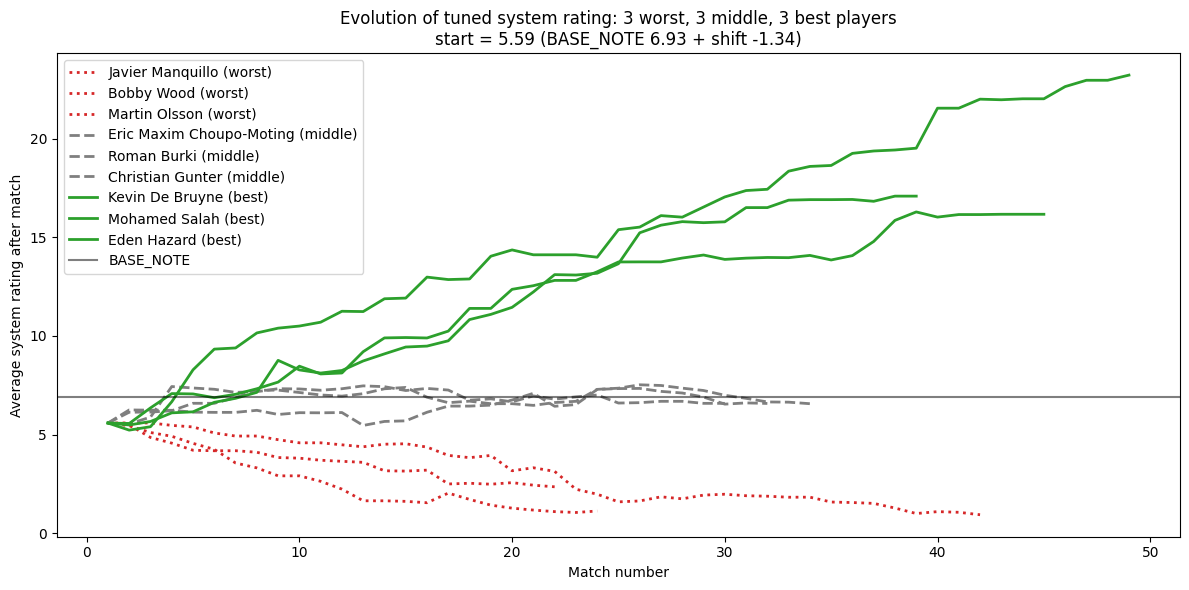

In [128]:
# Plot: Evolution of the “tuned” system rating (3 worst, 3 middle, 3 best)

assert 'ts_tuned' in globals() and 'fin_tuned' in globals(), "Run the tuned system calculation first."

n = 3  # number of players per group

best_players  = fin_tuned.head(n)['player'].tolist()
worst_players = fin_tuned.tail(n)['player'].tolist()
mid_start = max(0, len(fin_tuned)//2 - n//2)
mid_players  = fin_tuned.iloc[mid_start:mid_start+n]['player'].tolist()

def plot_group(players, style, color, suffix):
    for p in players:
        dfp = (ts_tuned[ts_tuned['player'] == p]
               .sort_values(['date','match'])
               .reset_index(drop=True))
        y = dfp['rating_after'].to_numpy()
        x = range(1, len(y)+1)
        plt.plot(x, y, linestyle=style, color=color, linewidth=2, label=f"{p} ({suffix})")

plt.figure(figsize=(12,6))
plot_group(worst_players, ':',  '#d62728', 'worst')
plot_group(mid_players,   '--', '#7f7f7f', 'middle')
plot_group(best_players,  '-',  '#2ca02c', 'best')


plt.axhline(BASE_NOTE, color='k', alpha=0.5, lw=1.5, label='BASE_NOTE')
plt.title(f"Evolution of tuned system rating: 3 worst, 3 middle, 3 best players\n"
          f"start = {start_value:.2f} (BASE_NOTE {BASE_NOTE:.2f} + shift {shift_applied:+.2f})")

plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [129]:
# Top 10 players per system: tuned, human-only, non-human-only

def _top10(df, col):
    return (df[['player', col]]
            .dropna()
            .sort_values(col, ascending=False)
            .head(10)
            .reset_index(drop=True)
            .assign(rank=lambda x: x.index + 1)
            .rename(columns={col: 'final_rating'}))

systems = []

# tuned
if 'fin_tuned' in globals():
    col_tuned = 'final_rating_tuned' if 'final_rating_tuned' in fin_tuned.columns else 'final_rating'
    systems.append(('tuned', _top10(fin_tuned, col_tuned)))

# human
if 'fin_hum' in globals():
    col_h = 'final_rating_human' if 'final_rating_human' in fin_hum.columns else 'final_rating'
    systems.append(('human', _top10(fin_hum, col_h)))

# non-human (AI)
if 'fin_ai' in globals():
    col_ai = 'final_rating_ai' if 'final_rating_ai' in fin_ai.columns else 'final_rating'
    systems.append(('ai', _top10(fin_ai, col_ai)))

# print and save
all_top = []
for name, df_top in systems:
    print(f"\nTop 10 - {name}")
    print(df_top[['rank', 'player', 'final_rating']])
    df_top_out = df_top.copy()
    df_top_out.insert(0, 'system', name)
    all_top.append(df_top_out)

if all_top:
    top10_by_system = pd.concat(all_top, ignore_index=True)
    save_result_csv(top10_by_system, "top10_by_system.csv", index=False)
    print("\nSaved top10_by_system.csv")
else:
    print("No systems found. Run the previous cells first.")


Top 10 - tuned
   rank             player  final_rating
0     1    Kevin De Bruyne     23.210703
1     2      Mohamed Salah     17.081520
2     3        Eden Hazard     16.162836
3     4         Leroy Sane     15.611191
4     5         Harry Kane     15.226982
5     6  Christian Eriksen     15.191592
6     7        David Silva     14.562231
7     8         Paul Pogba     14.512437
8     9      Sergio Aguero     14.030020
9    10              Naldo     13.950672

Top 10 - human
   rank           player  final_rating
0     1  Kevin De Bruyne     23.259992
1     2    Mohamed Salah     16.965888
2     3      David Silva     16.102159
3     4       Leroy Sane     16.029852
4     5  Raheem Sterling     15.497754
5     6      Eden Hazard     15.272883
6     7    Jiri Pavlenka     14.866457
7     8    Sergio Aguero     14.435520
8     9    Wilfried Zaha     14.162392
9    10    Koen Casteels     13.912382

Top 10 - ai
   rank             player  final_rating
0     1    Kevin De Bruyne     20.

# Case Study

In [130]:
# Table: 5 matches of Shkodran Mustafi with human and AI notes
import pandas as pd, re, unicodedata
from IPython.display import display

assert 'pm0' in globals(), "pm0 not found. Run the data prep cells first."

name = "Shkodran Mustafi"
k = 5  # number of matches to show

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    return re.sub(r"[^a-z0-9]+", " ", s).strip()

# Resolve exact player name
players = pm0['player'].dropna().unique()
norm_map = {_norm(p): p for p in players}
key = _norm(name)
if key not in norm_map:
    raise RuntimeError(f"Player '{name}' not found.")
player = norm_map[key]

# Select columns if present
candidates = ['date','competition','match','human_rating','non_human_rating']
avail = [c for c in candidates if c in pm0.columns]

dfp = (pm0.loc[pm0['player'] == player, avail].copy())

if 'date' in dfp.columns:
    dfp['date'] = pd.to_datetime(dfp['date'], errors='coerce')

# Keep rows where at least one note is available
if {'human_rating','non_human_rating'}.issubset(dfp.columns):
    dfp = dfp[(~dfp['human_rating'].isna()) | (~dfp['non_human_rating'].isna())]

# Sort by date (fallback to original order if no date), take k
sort_col = 'date' if 'date' in dfp.columns else None
if sort_col:
    dfp = dfp.sort_values(sort_col, ascending=False)
dfp = dfp.head(k).reset_index(drop=True)

# Rename and format
rename_map = {'human_rating':'human_note', 'non_human_rating':'ai_note'}
dfp = dfp.rename(columns=rename_map)
for c in ['human_note','ai_note']:
    if c in dfp.columns:
        dfp[c] = dfp[c].round(2)

# Order columns nicely
order = [c for c in ['date','competition','match','human_note','ai_note'] if c in dfp.columns]
display(dfp[order] if order else dfp)

,date,competition,match,human_note,ai_note
0,2018-11-03,Premier League 2017-18,"Arsenal - Watford, 3 - 0",7.65,8.63
1,2018-10-02,Premier League 2017-18,"Tottenham - Arsenal, 1 - 0",7.65,6.88
2,2018-09-05,Premier League 2017-18,"Leicester - Arsenal, 3 - 1",6.65,7.08
3,2018-08-04,Premier League 2017-18,"Arsenal - Southampton, 3 - 2",5.65,5.61
4,2018-04-03,Premier League 2017-18,"Brighton - Arsenal, 2 - 1",5.65,7.50


In [131]:
# Preconditions
assert 'ts_tuned' in globals() and 'pm0' in globals(), "Run the tuned system cells first."
target_name = "Shkodran Mustafi"

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", " ", s).strip()

# Resolve exact player name
players = set(ts_tuned['player'])
norm_map = {_norm(p): p for p in players}
key = _norm(target_name)
if key not in norm_map:
    raise RuntimeError(f"Player '{target_name}' not found in tuned series.")
player = norm_map[key]

# Context (minutes weight and difficulty)
ctx_cols = ["date","match","player","w_min","difficulty"]
pm_ctx = (globals().get("pm_best") if "pm_best" in globals() else pm0[ctx_cols]).copy()
pm_ctx = pm_ctx[ctx_cols].drop_duplicates()

# Merge tuned time series with context
df = (ts_tuned[ts_tuned["player"] == player]
        .sort_values(["date","match"])
        .merge(pm_ctx, on=["date","match","player"], how="left")
        .reset_index(drop=True))

# Exclude the seed row (NaN P/E)
df_eff = df[~(df["P"].isna() & df["E"].isna())].reset_index(drop=True)
if df_eff.empty:
    raise RuntimeError("No effective matches found for this player.")

# Pick a random match (reproducible)
row = df_eff.sample(1, random_state=17).iloc[0]

# Parameters used for the update
amp = float(globals().get("SELECTED_DIFF_UPDATE_AMP", 1.0))
diff_power = 1.0  # same default as in compute_ratings

# Extract inputs
before = float(row["rating_before"])
P      = float(row["P"])
E      = float(row["E"])
w_min  = float(row["w_min"]) if pd.notna(row["w_min"]) else 0.0
diff   = float(row["difficulty"]) if pd.notna(row["difficulty"]) else 0.5

# Compute scale and delta exactly like compute_ratings
t = (diff - 0.5) * 2.0
diff_term = np.sign(t) * (abs(t) ** diff_power)
scale = max(0.0, 1.0 + amp * diff_term)
delta_calc = K * w_min * scale * (P - E)
after_calc = before + delta_calc

# Observed after/delta from ts_tuned
after_obs = float(row["rating_after"])
delta_obs = after_obs - before

# Present the calculation
out = pd.DataFrame([{
    "date":        row["date"],
    "match":       row["match"],
    "rating_before": round(before, 4),
    "P_obs":         round(P, 4),
    "E_exp":         round(E, 4),
    "minutes_w":     round(w_min, 4),
    "difficulty":    round(diff, 4),
    "diff_term":     round(diff_term, 4),
    "scale":         round(scale, 4),
    "K":             K,
    "delta_calc":    round(delta_calc, 6),
    "delta_obs":     round(delta_obs, 6),
    "after_calc":    round(after_calc, 6),
    "after_obs":     round(after_obs, 6),
    "abs_error":     round(abs(after_calc - after_obs), 8)
}])

from IPython.display import display
print(f"Example update for {player}:")
display(out)

print("\nFormula:")
print("delta = K * minutes_w * scale * (P_obs - E_exp)")
print(f"     = {K:.3f} * {w_min:.3f} * {scale:.3f} * ({P:.3f} - {E:.3f}) = {delta_calc:.6f}")
print(f"rating_after = rating_before + delta = {before:.6f} + {delta_calc:.6f} = {after_calc:.6f}")

Example update for Shkodran Mustafi:


,date,match,rating_before,P_obs,E_exp,minutes_w,difficulty,diff_term,scale,K,delta_calc,delta_obs,after_calc,after_obs,abs_error
0,2016-07-07,"Germany - France, 0 - 2",5.5896,6.3848,6.4794,0.3222,0.9474,0.8947,1.8947,0.35,-0.020195,-0.020195,5.569455,5.569455,0.0



Formula:
delta = K * minutes_w * scale * (P_obs - E_exp)
     = 0.350 * 0.322 * 1.895 * (6.385 - 6.479) = -0.020195
rating_after = rating_before + delta = 5.589649 + -0.020195 = 5.569455


Player selected: Shkodran Mustafi


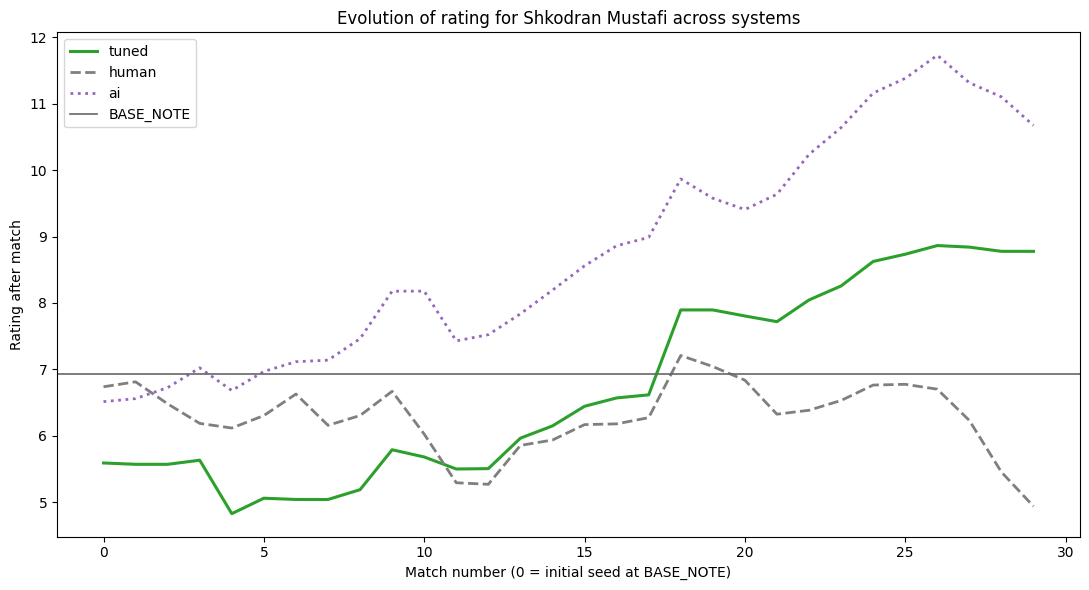

In [132]:
# Evolution of Shkodran Mustafi across tuned, human, and AI ratings
import numpy as np
import matplotlib.pyplot as plt
import re, unicodedata

# Preconditions
assert 'ts_tuned' in globals() and 'ts_hum' in globals() and 'ts_ai' in globals(), "Run previous cells first."
target_name = "Shkodran Mustafi"

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    return re.sub(r"\s+", " ", re.sub(r"[^a-z0-9]+", " ", s)).strip()

# Resolve exact player name present in the time series (case/accents-insensitive)
players_union = set(ts_tuned['player']).union(ts_hum['player']).union(ts_ai['player'])
norm_map = {_norm(p): p for p in players_union}
key = _norm(target_name)
if key not in norm_map:
    raise RuntimeError(f"Player '{target_name}' not found in any system.")
player = norm_map[key]
print(f"Player selected: {player}")

def series_for(ts, player):
    dfp = (ts[ts['player'] == player]
           .sort_values(['date','match'])
           .reset_index(drop=True))
    x = np.arange(len(dfp))  # 0 includes the initial seed at BASE_NOTE
    y = dfp['rating_after'].to_numpy()
    return x, y

x_t, y_t = series_for(ts_tuned, player)
x_h, y_h = series_for(ts_hum,   player)
x_a, y_a = series_for(ts_ai,    player)

plt.figure(figsize=(11,6))
plt.plot(x_t, y_t, color='tab:green',  lw=2.2, label='tuned')
plt.plot(x_h, y_h, color='tab:gray',   lw=2.0, ls='--', label='human')
plt.plot(x_a, y_a, color='tab:purple', lw=2.0, ls=':',  label='ai')

plt.axhline(BASE_NOTE, color='0.4', lw=1.2, label='BASE_NOTE')
plt.title(f"Evolution of rating for {player} across systems")
plt.xlabel("Match number (0 = initial seed at BASE_NOTE)")
plt.ylabel("Rating after match")
plt.legend()
plt.tight_layout()

plt.show()

In [133]:
name = "Shkodran Mustafi"

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", " ", s).strip()

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError("No final rating column found.")

def _final_and_rank(df, candidates):
    col = _pick_col(df, candidates)
    d = df[["player", col]].dropna().copy()
    d["_key"] = d["player"].apply(_norm)
    d["rank"] = d[col].rank(method="min", ascending=False).astype(int)
    N = len(d)
    row = d[d["_key"] == _norm(name)]
    if row.empty:
        return np.nan, np.nan, N
    return float(row.iloc[0][col]), int(row.iloc[0]["rank"]), N

assert 'fin_tuned' in globals() and 'fin_hum' in globals() and 'fin_ai' in globals(), "Run previous cells first."

tuned_rating, tuned_rank, n_tuned = _final_and_rank(fin_tuned, ["final_rating_tuned","final_rating"])
human_rating, human_rank, n_human = _final_and_rank(fin_hum,   ["final_rating_human","final_rating"])
ai_rating,    ai_rank,    n_ai    = _final_and_rank(fin_ai,    ["final_rating_ai","final_rating"])

out = pd.DataFrame([
    {"system": "tuned", "final_rating": tuned_rating, "rank": tuned_rank, "n_players": n_tuned},
    {"system": "human", "final_rating": human_rating, "rank": human_rank, "n_players": n_human},
    {"system": "ai",    "final_rating": ai_rating,    "rank": ai_rank,    "n_players": n_ai},
])

out["final_rating"] = out["final_rating"].round(3)

from IPython.display import display
display(out)

,system,final_rating,rank,n_players
0,tuned,8.778,94,524
1,human,4.937,423,524
2,ai,10.674,33,524
